# The Attention Unet model from MONAI
The Attention Unet model was adapted from MONAI and adjusted to 2D version of the dataset

## Load libraries

In [1]:
import os
import shutil
import tempfile
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)
from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from monai.metrics import DiceMetric
from monai.losses import DiceCELoss
from monai.losses import DiceLoss, TverskyLoss, FocalLoss

import torch
import einops
import warnings




warnings.filterwarnings("ignore")
import torch
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available() 
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name(0)

'NVIDIA A40'

### Check your location

In [ ]:

# Check the amount of shared memory
os.system('df -h /dev/shm')

import os
dir = os.getcwd()
print('Current directory is:',dir)


warnings.filterwarnings("ignore")

# Train and validate the model

## Set the training model parametres

In [4]:
# Import libraries
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from monai.networks.nets import AttentionUnet
from monai.losses import DiceLoss, DiceCELoss
from monai.losses import GeneralizedWassersteinDiceLoss
from torch.nn.modules.loss import BCEWithLogitsLoss
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import jaccard_score
import seaborn as sns
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import csv
import random
from torchvision.transforms import functional
from torchvision.transforms import v2
# Import custom transforms
import utils.custom_transform as T
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define transformation classes for augmentations during the training
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for transform in self.transforms:
            image, target = transform(image, target)
        return image, target

class RandomHorizontalFlip:
    def __init__(self, flip_prob=0.5):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        if random.random() < self.flip_prob:
            image = functional.hflip(image)
            target = functional.hflip(target)
        return image, target

class RandomVerticalFlip:
    def __init__(self, flip_prob=0.5):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        if random.random() < self.flip_prob:
            image = functional.vflip(image)
            target = functional.vflip(target)
        return image, target

# Import the dataset from JSON and define its parametres
class NumpyDataset(Dataset):
    """Custom Dataset for loading images and labels from numpy files."""

    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        label = np.load(self.label_paths[idx])

        image = self.replace_nans_in_array(image)
        label = self.replace_nans_in_array(label)

        image = torch.tensor(image, dtype=torch.float32)  # Shape: [1, 14, 48, 48]
        label = torch.tensor(label, dtype=torch.float32)  # Shape: [1, 48, 48]

        # Apply transformations if specified
        if self.transform is not None:
            image, label = self.transform(image, label)

        return image, label

    @staticmethod
    def replace_nans_in_array(arr):
        """Replace NaNs and Infs in an array with 0."""
        arr[np.isnan(arr)] = 0
        arr[np.isinf(arr)] = 0
        return arr

def load_dataset_json(json_path):
    """Load dataset paths from a JSON file."""
    with open(json_path, 'r') as file:
        dataset_json = json.load(file)
    return dataset_json

def prepare_data_loaders(train_paths, val_paths, test_paths, batch_size, transform=None):
    """Prepare DataLoader objects for training and validation datasets."""
    train_images = [item['image'] for item in train_paths]
    train_labels = [item['label'] for item in train_paths]
    val_images = [item['image'] for item in val_paths]
    val_labels = [item['label'] for item in val_paths]
    test_images = [item['image'] for item in test_paths]
    test_labels = [item['label'] for item in test_paths]

    train_dataset = NumpyDataset(train_images, train_labels, transform=transform)
    val_dataset = NumpyDataset(val_images, val_labels)
    test_dataset = NumpyDataset(test_images, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader
    
# The parameters of the DL model used
# AttentionUnet from MONAI
def initialize_model():
    """Initialize the AttentionUnet model."""
    model = AttentionUnet(
        spatial_dims=2,
        in_channels=48,
        out_channels=1,
        #use_checkpoint=True,
        channels=(16, 32, 64, 128, 256),
        strides=(2,2,2,2),
        kernel_size=3,
        up_kernel_size=3,
        dropout=0.0
    )
    return model


def check_for_nans(tensor, name='Tensor'):
    """Check for NaNs or Infs in a tensor and raise an error if any are found."""
    if torch.isnan(tensor).any() or torch.isinf(tensor).any():
        raise ValueError(f"{name} contains NaNs or Infs")

def train_model(model, train_loader, val_loader, device, num_epochs, learning_rate, patience, weight_decay, early_stopping_enabled):
    """Train the model with early stopping and log the results."""
    model.to(device)
    torch.backends.cudnn.benchmark = True
    loss_function = DiceCELoss
    #criterion = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)
    criterion = loss_function(include_background=True, to_onehot_y=False, softmax=True)

    optimizer = optim.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # The training uses the scheduler to modify the lr depending on the process of the training 
    lr_scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='min',      # Reduce learning rate (lr) when metric stops improving
        factor=0.5,      # Reduce lr by 50%
        patience=10,     # Number of epochs with no improvement after which lr will be reduced
        verbose=True,    # Print a message when lr changes
        min_lr=1e-6      # Minimum learning rate
    )
    scaler = torch.cuda.amp.GradScaler()

    best_val_loss = float('inf')
    early_stopping_enabled = bool
    epochs_without_improvement = 0
    train_losses = []
    val_losses = []
    
    ## Here we create a csv file, which will store metrics calculated for reach epoch
    with open('model/Att_UNET/Aug/bin_model_results_lr_B.csv', 'w', newline='') as csvfile:
        fieldnames = ['Epoch', 'Train_Loss', 'Val_Loss', 'Precision', 'Recall', 'F1_Score', 'IoU_Score', 'Average_precision', 'Accuracy', 'Balanced_accuracy', 'Roc_auc', 'Jaccard_score']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                outputs = model(inputs)
                outputs = torch.sigmoid(outputs)  # Apply sigmoid

                if labels.dim() == 3:
                    labels = labels.unsqueeze(1)  # Ensure channel dimension

                check_for_nans(inputs, 'Inputs')
                check_for_nans(labels, 'Labels')
                check_for_nans(outputs, 'Outputs')

                if labels.shape != outputs.shape:
                    raise AssertionError(f"Mismatch in shapes: Outputs ({outputs.shape}), Labels ({labels.shape})")

                loss = criterion(outputs, labels)
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)
            train_losses.append(epoch_loss)
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

            model.eval()
            val_running_loss = 0.0
            all_labels = []
            all_outputs = []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    outputs = torch.sigmoid(outputs)  # Apply sigmoid

                    if labels.dim() == 3:
                        labels = labels.unsqueeze(1)  # Ensure channel dimension

                    check_for_nans(inputs, 'Inputs')
                    check_for_nans(labels, 'Labels')
                    check_for_nans(outputs, 'Outputs')

                    loss = criterion(outputs, labels)
                    val_running_loss += loss.item() * inputs.size(0)

                    all_labels.extend(labels.cpu().numpy().flatten())
                    all_outputs.extend((outputs.cpu().numpy() > 0.5).astype(int).flatten())

            epoch_val_loss = val_running_loss / len(val_loader.dataset)
            lr_scheduler.step(epoch_val_loss)
            val_losses.append(epoch_val_loss)
            print(f"Validation Loss: {epoch_val_loss:.4f}")
            avg_val_loss = epoch_val_loss / len(val_loader)
            
            average_precision = average_precision_score(all_labels, all_outputs)
            precision = precision_score(all_labels, all_outputs, zero_division=1)
            recall = recall_score(all_labels, all_outputs, zero_division=1)
            f1 = f1_score(all_labels, all_outputs, zero_division=1)
            accuracy = accuracy_score(all_labels, all_outputs, normalize=False)
            balanced_accuracy = balanced_accuracy_score(all_labels, all_outputs)
            fpr, tpr, thresholds = roc_curve(all_labels, all_outputs)           
            roc_auc = roc_auc_score(all_labels, all_outputs)   
            jaccard_sim_score = jaccard_score(all_labels, all_outputs, average="micro")
           # Compute IoU score
            iou_scores = compute_iou(all_outputs, all_labels)  # No need to call .tolist()
            avg_iou = np.mean(iou_scores)            
            print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, IoU Scores: {avg_iou:.4f}, Average precision: {average_precision:.4f}, Accuracy: {accuracy:.4f}, Balanced accuracy: {balanced_accuracy:.4f}, Roc auc: {roc_auc:.4f}, Jaccard score: {jaccard_sim_score:.4f}")

            # Save the metrics in CSV
            writer.writerow({
                'Epoch': epoch + 1,
                'Train_Loss': epoch_loss,
                'Val_Loss': epoch_val_loss,
                'Precision': precision,
                'Average_precision': average_precision,
                'Recall': recall,
                'F1_Score': f1,
                'IoU_Score': avg_iou,
                'Accuracy': accuracy,
                'Balanced_accuracy': balanced_accuracy,
                'Roc_auc': roc_auc,
                'Jaccard_score': jaccard_sim_score
            })
            csvfile.flush()  # Ensure the data is written to disk

            # The model allows to save both last and best versions
            torch.save(model.state_dict(), 'model/Att_UNET/Aug/bin_last_model_lr_B.pth')
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), 'model/Att_UNET/Aug/bin_best_model_lr_B.pth')
                patience_counter = 0
            else:
                patience_counter += 1
                if early_stopping_enabled and patience_counter >= patience:
                    print("Early stopping")
                    break
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current Learning Rate: {current_lr}")

    return train_losses, val_losses

## Define automatic plots and print metrics
### Loss plot
def plot_losses(train_losses, val_losses):
    """Plot and save training and validation losses."""
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.savefig('model/loss_plot.png')  # Save the plot as PNG
    plt.show()

### Calculate final metrics
def calculate_metrics(outputs, labels):
    outputs = (outputs > 0.5).astype(int)
    labels = labels.astype(int)
    
    precision = precision_score(labels.flatten(), outputs.flatten(), zero_division=1)
    recall = recall_score(labels.flatten(), outputs.flatten(), zero_division=1)
    f1 = f1_score(labels.flatten(), outputs.flatten(), zero_division=1)
    cm = confusion_matrix(labels.flatten(), outputs.flatten())
    
    return precision, recall, f1, cm

### ROC curve
def plot_roc_curve(y_true, y_scores):

    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', linewidth=0.5)
    
    # Save the plot
    plt.savefig('model/roc_curve.png')
    plt.close()

    return roc_auc, fpr, tpr, thresholds

### IoU
def compute_iou(predictions, labels, smooth=1e-6):

    # Convert to NumPy arrays if input is a list
    if isinstance(predictions, list):
        predictions = np.array(predictions)
    if isinstance(labels, list):
        labels = np.array(labels)

    # Convert to PyTorch tensors if input is NumPy array
    if isinstance(predictions, np.ndarray):
        predictions = torch.tensor(predictions)
    if isinstance(labels, np.ndarray):
        labels = torch.tensor(labels)

    # Ensure tensors are on the same device and dtype
    predictions = predictions.to(dtype=torch.float32)
    labels = labels.to(dtype=torch.float32)

    # Ensure binary masks (for IoU calculation)
    predictions = (predictions > 0.5).float()
    labels = (labels > 0.5).float()

    # Compute intersection and union
    intersection = (predictions * labels).sum()
    union = predictions.sum() + labels.sum() - intersection

    # Compute IoU score
    iou_score = (intersection + smooth) / (union + smooth)

    return iou_score.item()

### Confusion matrix
def plot_confusion_matrix(cm):
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.title('Confusion Matrix (Percentage)')
    plt.savefig('model/Att_UNET/Aug/CF.png')

    plt.show()
    
    # Save the plot

## Define additional functions
### Predict and evaluate the model
def predict_and_evaluate(model, test_loader, device):
    model.eval()
    model.to(device)

    all_labels = []
    all_outputs = []
    all_probs = []  # Store raw probabilities

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy()
            binary_outputs = (probs > 0.5).astype(int)
            
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(binary_outputs)
            all_probs.extend(probs)

    all_labels = np.array(all_labels).flatten()
    all_outputs = np.array(all_outputs).flatten()
    all_probs = np.array(all_probs).flatten()
    
    # Calculate metrics
    precision, recall, f1, cm = calculate_metrics(all_outputs, all_labels)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
    # Calculate and plot ROC curve
    roc_auc, fpr, tpr, thresholds = plot_roc_curve(all_labels, all_probs)
    
    print(f"ROC AUC Score: {roc_auc:.4f}")
    
    return all_outputs, all_labels, cm, roc_auc

### Display predictions
def display_predictions(inputs, labels, outputs):
    for i in range(inputs.shape[0]):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(inputs[i, 0, :, :], cmap='gray')
        axs[0].set_title('Input Image')

        axs[1].imshow(labels[i, 0, :, :], cmap='gray')
        axs[1].set_title('Ground Truth')

        axs[2].imshow(outputs[i, 0, :, :], cmap='gray')
        axs[2].set_title('Prediction')

        plt.show()
   

## Start training the model

Epoch 1/500, Loss: 0.8595
Validation Loss: 0.8302
Precision: 0.1105, Recall: 0.4878, F1 Score: 0.1802, IoU Scores: 0.0990, Average precision: 0.1132, Accuracy: 542117.0000, Balanced accuracy: 0.4869, Roc auc: 0.4869, Jaccard score: 0.3211
Epoch 2/500, Loss: 0.8604
Validation Loss: 0.8301
Precision: 0.1101, Recall: 0.4833, F1 Score: 0.1793, IoU Scores: 0.0985, Average precision: 0.1130, Accuracy: 544179.0000, Balanced accuracy: 0.4859, Roc auc: 0.4859, Jaccard score: 0.3227
Epoch 3/500, Loss: 0.8590
Validation Loss: 0.8300
Precision: 0.1104, Recall: 0.4843, F1 Score: 0.1798, IoU Scores: 0.0988, Average precision: 0.1132, Accuracy: 544755.0000, Balanced accuracy: 0.4867, Roc auc: 0.4867, Jaccard score: 0.3232
Epoch 4/500, Loss: 0.8581
Validation Loss: 0.8290
Precision: 0.1127, Recall: 0.4869, F1 Score: 0.1831, IoU Scores: 0.1008, Average precision: 0.1143, Accuracy: 554179.0000, Balanced accuracy: 0.4926, Roc auc: 0.4926, Jaccard score: 0.3306
Epoch 5/500, Loss: 0.8562
Validation Loss: 0

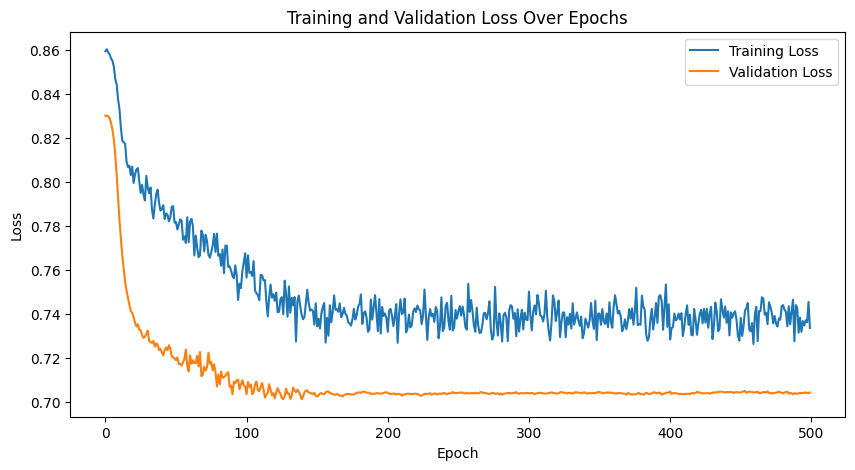

Precision: 0.2645, Recall: 0.6806, F1 Score: 0.3810
ROC AUC Score: 0.7440
IoU scores 0.23533643782138824


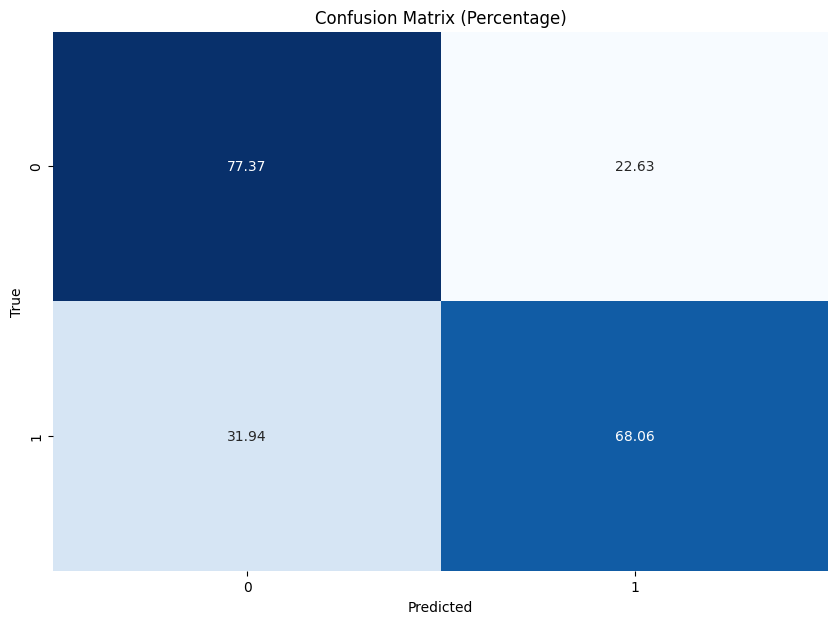

In [5]:


if __name__ == "__main__":
    # Load dataset paths from JSON file
    dataset_json = load_dataset_json(os.path.join('data', 'dataset_bin.json'))

    train_paths = dataset_json['training']
    val_paths = dataset_json['validation']
    test_paths = dataset_json['testing']

    batch_size = 48

    # Define transformations
    transform = T.Compose([T.RandomHorizontalFlip(), T.RandomVerticalFlip(), T.RandomRotate()])

    # Prepare DataLoader objects
    train_loader, val_loader, test_loader = prepare_data_loaders(train_paths, val_paths, test_paths, batch_size, transform=transform)

    # Initialize the model
    model = initialize_model()


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_epochs = 500
    learning_rate = 2e-4
    weight_decay = 5e-6
    patience = 500
    early_stopping_enabled = False
    
    # Train the model and plot the losses
    train_losses, val_losses = train_model(model, train_loader, val_loader, device, num_epochs, learning_rate, patience, weight_decay, early_stopping_enabled)
    plot_losses(train_losses, val_losses)

    all_outputs, all_labels, cm, roc_auc = predict_and_evaluate(model, test_loader, device)

    iou_scores = compute_iou(all_outputs, all_labels)  
    print("IoU scores", iou_scores)
    plot_confusion_matrix(cm)



## Show plots

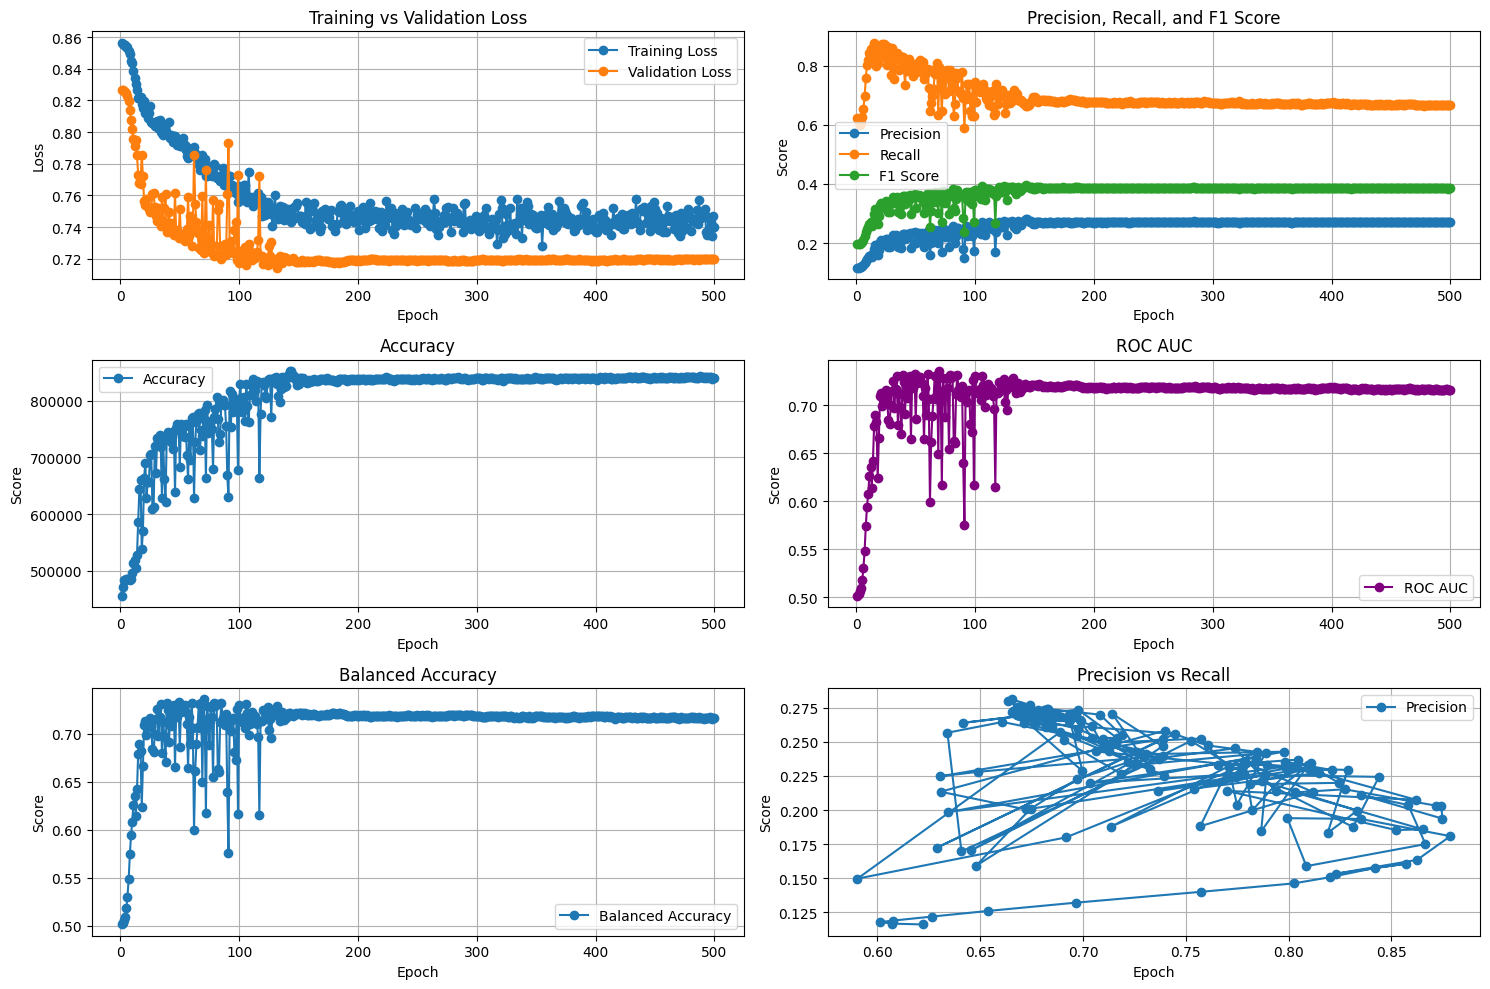

In [5]:
import pandas as pd

# Load the data from the uploaded file
file_path = 'model/Att_UNET/Aug/bin_model_results_lr_B.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand its structure
data.head()

import matplotlib.pyplot as plt

# Set up subplots for visualizing key metrics
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# Loss Curves
axes[0, 0].plot(data['Epoch'], data['Train_Loss'], label='Training Loss', marker='o')
axes[0, 0].plot(data['Epoch'], data['Val_Loss'], label='Validation Loss', marker='o')
axes[0, 0].set_title('Training vs Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Precision, Recall, and F1 Score
axes[0, 1].plot(data['Epoch'], data['Precision'], label='Precision', marker='o')
axes[0, 1].plot(data['Epoch'], data['Recall'], label='Recall', marker='o')
axes[0, 1].plot(data['Epoch'], data['F1_Score'], label='F1 Score', marker='o')
axes[0, 1].set_title('Precision, Recall, and F1 Score')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Score')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Accuracy
axes[1, 0].plot(data['Epoch'], data['Accuracy'], label='Accuracy', marker='o')
axes[1, 0].set_title('Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].legend()
axes[1, 0].grid(True)

# ROC AUC
axes[1, 1].plot(data['Epoch'], data['Roc_auc'], label='ROC AUC', marker='o', color='purple')
axes[1, 1].set_title('ROC AUC')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Balanced Accuracy
axes[2, 0].plot(data['Epoch'], data['Balanced_accuracy'], label='Balanced Accuracy', marker='o')
axes[2, 0].set_title('Balanced Accuracy')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Score')
axes[2, 0].legend()
axes[2, 0].grid(True)



# Precision, Recall, and F1 Score
axes[2, 1].plot(data['Recall'], data['Precision'], label='Precision', marker='o')
axes[2, 1].set_title('Precision vs Recall')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Score')
axes[2, 1].legend()
axes[2, 1].grid(True)


# Adjust layout and display the plots
plt.tight_layout()
plt.show()

